In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV2
from torch_geometric.data import DataLoader 
from model import Net
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
#1: Load Data + Model
#1.1: Load Data
testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV2(testpath, max_events=12000, inp = 'test')

test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

data_path = '/vols/cms/mm1221/Data/100k/5e/test/raw/test.root'
data_file = uproot.open(data_path)

Track_ind = data_file['tracksters;1']['vertices_indexes'].array()

GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()

GT_bc = data_file['simtrackstersCP;3']['barycenter_x'].array()
energies = data_file['clusters;3']['energy'].array()
LC_x = data_file['clusters;3']['position_x'].array()
LC_y = data_file['clusters;3']['position_y'].array()
LC_z = data_file['clusters;3']['position_z'].array()
LC_eta = data_file['clusters;3']['position_eta'].array()
MT_ind = data_file['trackstersMerged;2']['vertices_indexes'].array()

#1.3 Filter so the same indexes are included for fair comparison




#1.2: Load Model

model = Net(64, 4, 0.1, 128)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/StaticEdge/results/Run1/results_lr0.0001_bs64_hd64_nl4_do0.1_k8_cd128/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)  
model.eval()  

### Loading tracksters data


100%|█████████████████████████████████████████████| 1/1 [01:10<00:00, 70.84s/it]
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-3): 4 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [4]:
import awkward as ak 
# Filter step, not needed!!!! 
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []

# Iterate over each event
for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [5]:
#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    edge_index = knn_graph(data.x, k=8)  
    predictions = model(data.x, edge_index, 1)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A

all_cluster_labels = Aggloremative(all_predictions, threshold = 0.18)

end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time
inference_time = time_diff/len(all_cluster_labels)
print("average inference time:", inference_time)



average inference time: 0.006361015486717224


In [6]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN



In [10]:
df_CL = pd.read_csv('df_scores_noRepeats.csv')
df_TICL = pd.read_csv('df_CERN_noRepeats.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'df_scores_noRepeats.csv'

In [8]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    cp_valid = df.dropna(subset=['cp_id']).copy()
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped['sim_to_reco_score'].min() < 0.2
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Average Energy Ratio Calculation -----
    low_score_mask = df['sim_to_reco_score'] < 0.2
    low_score_events = df[low_score_mask]
    if not low_score_events.empty:
        avg_energy_ratio = (low_score_events['trackster_energy'] / low_score_events['cp_energy']).mean()
    else:
        avg_energy_ratio = 0

    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")
    print(f"Average Energy Ratio: {avg_energy_ratio:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'avg_energy_ratio': avg_energy_ratio,
    }

# Example usage

your_model_metrics = calculate_metrics(df_CL, "Your Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")


Model: Your Model
Efficiency: 0.8861 (26524 associated CPs out of 29934 total CPs)
Purity: 0.9975 (34416 associated Tracksters out of 34502 total Tracksters)
Num tracksters ratio: 1.1526
Average Energy Ratio: 1.0866

Model: CERN Model
Efficiency: 0.8825 (26331 associated CPs out of 29838 total CPs)
Purity: 0.9964 (24863 associated Tracksters out of 24954 total Tracksters)
Num tracksters ratio: 0.8363
Average Energy Ratio: 1.8224


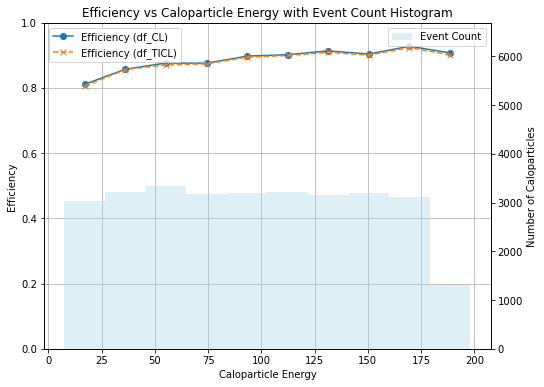

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Preprocessing
# -----------------------------
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['sim_to_reco_score'] = pd.to_numeric(df['sim_to_reco_score'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

# -----------------------------
# Prepare Caloparticle-Level Data
# -----------------------------
def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy (they are assumed to be identical).
      - Take the minimum sim_to_reco_score.
      - Mark the caloparticle as 'reconstructed' if min(sim_to_reco_score) < 0.2.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',          # Use the first cp_energy value.
        'sim_to_reco_score': 'min'       # Minimum score among the rows for that cp.
    }).reset_index()
    
    # Mark as reconstructed if any sim_to_reco_score < 0.2.
    grouped['reco'] = (grouped['sim_to_reco_score'] < 0.2).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp   = prepare_cp_data(df_TICL)
# -----------------------------
# Bin Caloparticles by Energy
# -----------------------------
# Define energy bins based on the range of cp_energy from df_CL.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = df_CL_cp['cp_energy'].max()
n_bins = 10  # Adjust the number of bins if desired.
# Create n_bins bins (n_bins+1 edges).
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin']   = pd.cut(df_TICL_cp['cp_energy'],   bins=energy_bins, labels=False, include_lowest=True)


# -----------------------------
# Calculate Efficiency per Energy Bin
# -----------------------------
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL   = aggregate_efficiency(df_TICL_cp)


# -----------------------------
# Plot Efficiency vs Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

# Create a figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Plot the efficiency curves on ax1.
ax1.plot(bin_centers, agg_CL['efficiency'], marker='o', linestyle='-', label='Efficiency (df_CL)')
ax1.plot(bin_centers, agg_TICL['efficiency'],   marker='x', linestyle='--', label='Efficiency (df_TICL)')
ax1.set_xlabel('Caloparticle Energy')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot the histogram (number of caloparticles per energy bin) on ax2.
# Here we use the counts from df_CL.
ax2.bar(bin_centers, agg_CL['total_cp'], width=bar_width, 
        color='lightblue', alpha=0.4, label='Event Count')
ax2.set_ylim(0, agg_CL['total_cp'].max()*2)
ax2.set_ylabel('Number of Caloparticles')
ax2.legend(loc='upper right')

plt.title('Efficiency vs Caloparticle Energy with Event Count Histogram')
plt.show()

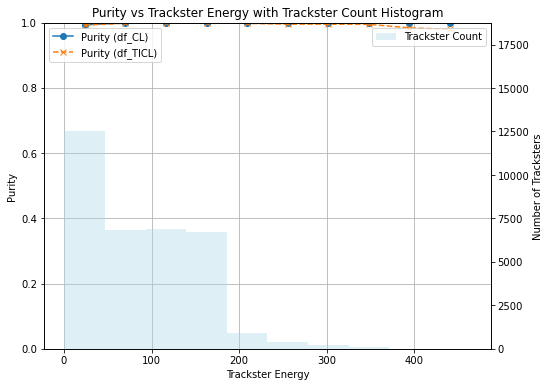

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Preprocessing
# -----------------------------
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy (assumed to be identical across rows),
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = df_CL_ts['trackster_energy'].max()
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

# Create a figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Plot purity curves on the primary y-axis.
ax1.plot(bin_centers_ts, agg_CL_ts['purity'], marker='o', linestyle='-', label='Purity (df_CL)')
ax1.plot(bin_centers_ts, agg_TICL_ts['purity'], marker='x', linestyle='--', label='Purity (df_TICL)')
ax1.set_xlabel('Trackster Energy')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax2.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts,
        color='lightblue', alpha=0.4, label='Trackster Count')
ax2.set_ylabel('Number of Tracksters')
ax2.set_ylim(0, (agg_CL_ts['total_ts'].max() or 1) * 1.5)
ax2.legend(loc='upper right')

plt.title('Purity vs Trackster Energy with Trackster Count Histogram')
plt.show()

# Response and Resolution

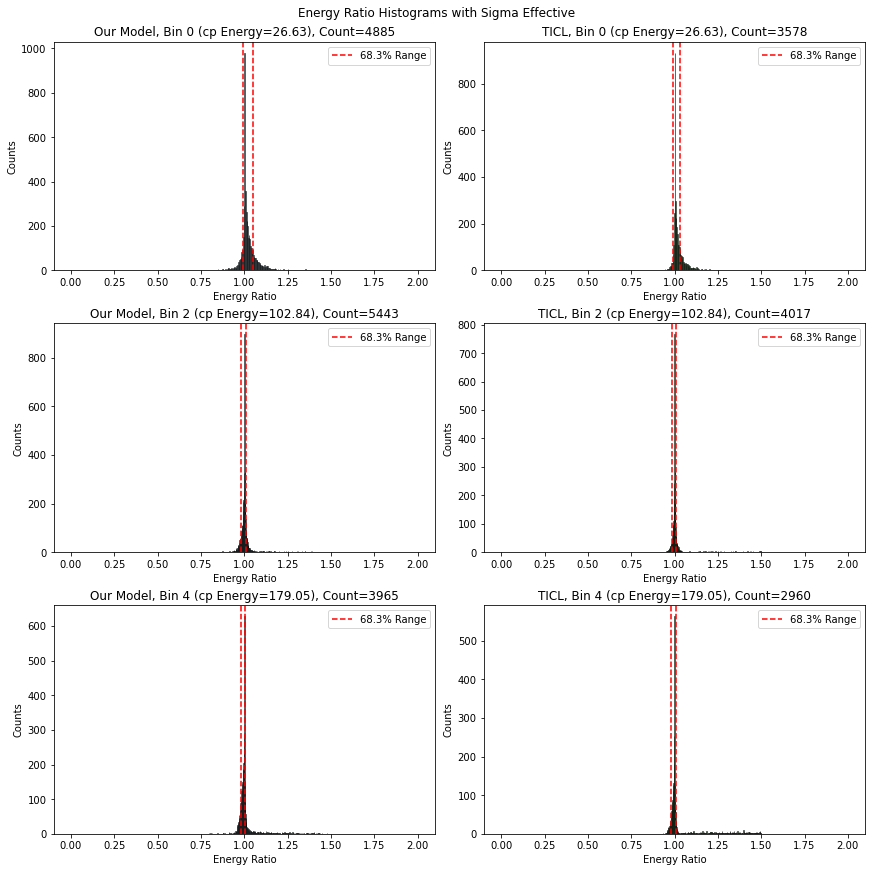

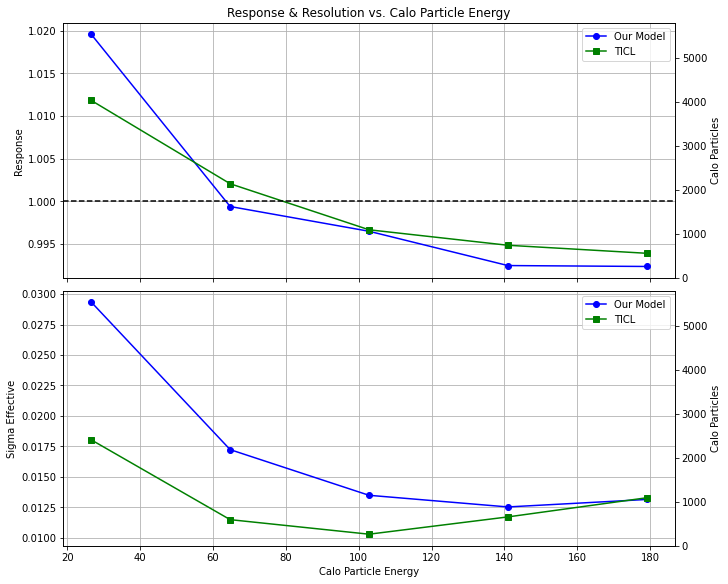

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# 1. Preprocessing and Association Selection for Calo Particles
# ====================================================
def process_cp_dataframe(df):
    df = df.copy()
    for col in ['cp_id', 'sim_to_reco_score', 'reco_to_sim_score', 'cp_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_cp = df[df['sim_to_reco_score'] < 0.2]
    df_cp = df_cp[(df_cp['energy_ratio'] >= 0.5) & (df_cp['energy_ratio'] <= 1.5)]
    df_cp = df_cp.loc[df_cp.groupby(['event_index', 'cp_id'])['sim_to_reco_score'].idxmin()].reset_index(drop=True)
    return df_cp

df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# ====================================================
# 2. Binning by Calo Particle Energy (cp_energy)
# ====================================================
n_bins = 5
energy_bins = np.histogram_bin_edges(df_CL_cp['cp_energy'], bins=n_bins)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

df_CL_cp['energy_bin'] = np.digitize(df_CL_cp['cp_energy'], bins=energy_bins) - 1
df_TICL_cp['energy_bin'] = np.digitize(df_TICL_cp['cp_energy'], bins=energy_bins) - 1

# ====================================================
# 3. Compute Sigma Effective in Each Energy Bin
# ====================================================
def compute_sigma_effective(df, n_bins):
    fitted_mean, sigma_eff, counts = [], [], []
    for b in range(n_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        sorted_data = np.sort(bin_data)
        n_points = len(sorted_data)
        if n_points > 0:
            window_size = int(0.683 * n_points)
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2
            sigma_eff_val = (best_range[1] - best_range[0]) / 2
        else:
            mu_eff, sigma_eff_val = np.nan, np.nan
        fitted_mean.append(mu_eff)
        sigma_eff.append(sigma_eff_val)
    return np.array(fitted_mean), np.array(sigma_eff), np.array(counts)

fitted_mean_CL, sigma_eff_CL, counts_CL = compute_sigma_effective(df_CL_cp, n_bins)
fitted_mean_TICL, sigma_eff_TICL, counts_TICL = compute_sigma_effective(df_TICL_cp, n_bins)

# ====================================================
# 4. Plot Histograms with Sigma Effective
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for j, (df, mean, sigma, label, color, ax) in enumerate(zip(
            [df_CL_cp, df_TICL_cp],
            [fitted_mean_CL, fitted_mean_TICL],
            [sigma_eff_CL, sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs])):
        data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        n, bins, _ = ax.hist(data, bins='auto', range=(0, 2), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean[b] - sigma[b], color='r', linestyle='--', label=f'68.3% Range')
        ax.axvline(mean[b] + sigma[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy={bin_centers[b]:.2f}), Count={len(data)}')
        ax.set_xlabel('Energy Ratio')
        ax.set_ylabel('Counts')
        ax.legend()
plt.suptitle('Energy Ratio Histograms with Sigma Effective')
plt.show()

# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
# ====================================================
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

ax_resp.plot(bin_centers, fitted_mean_CL, 'bo-', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, 'gs-', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()
ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=0.1, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Calo Particles')

ax_res.plot(bin_centers, sigma_eff_CL, 'bo-', label='Our Model')
ax_res.plot(bin_centers, sigma_eff_TICL, 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel('Sigma Effective')
ax_res.legend()
ax_res.grid()
ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=0.1, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')
plt.show()


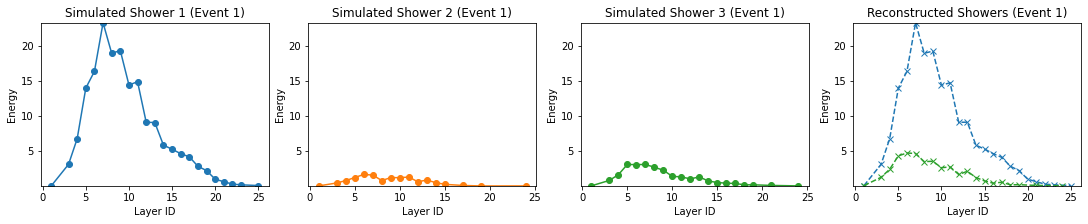

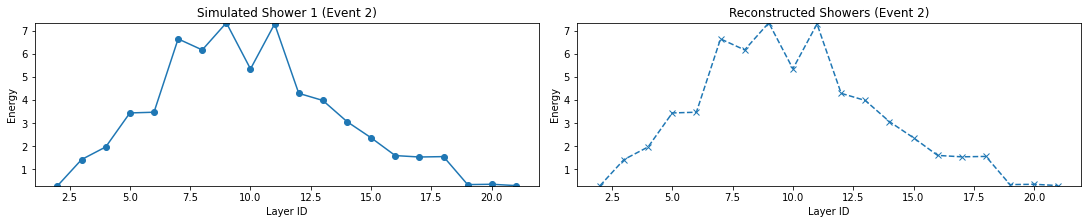

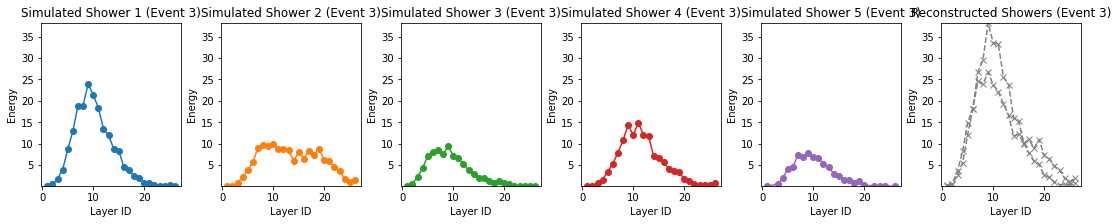

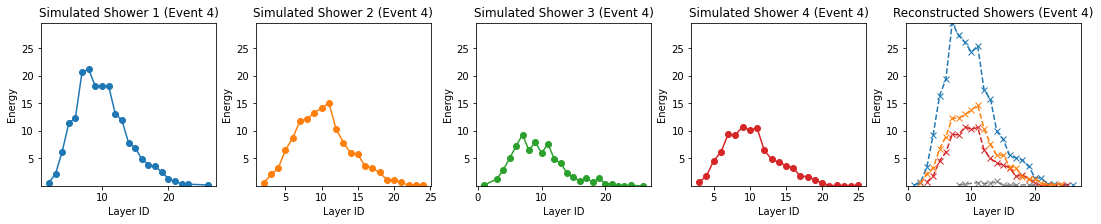

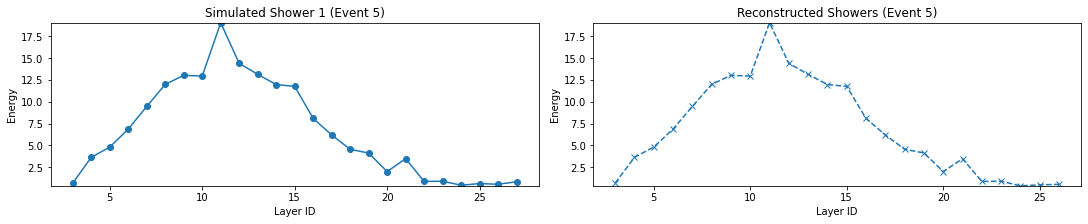

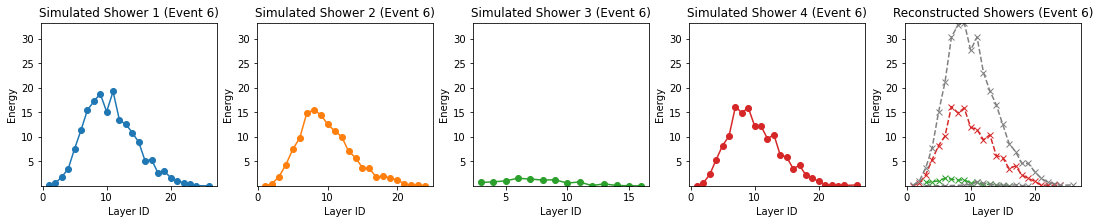

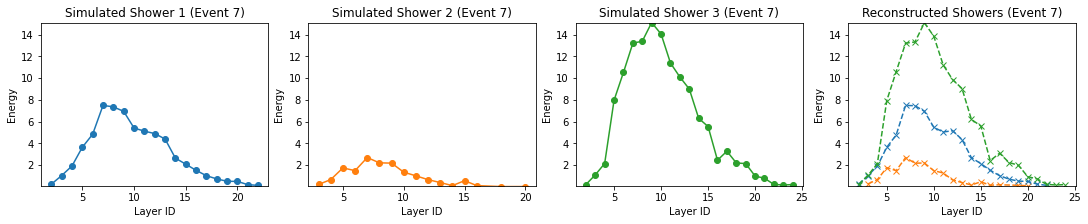

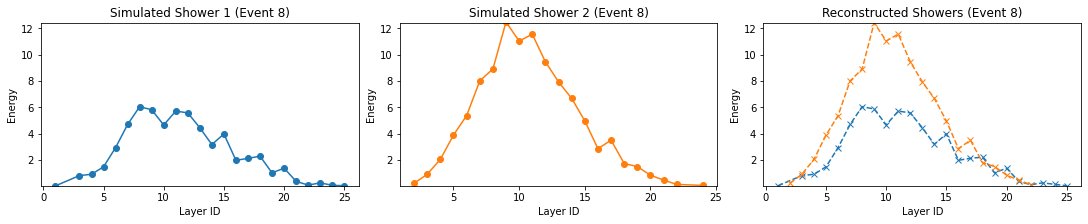

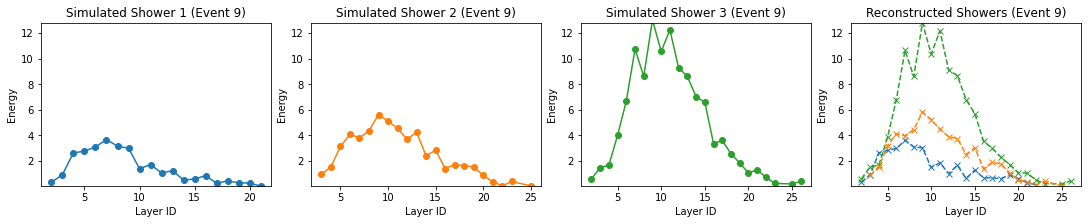

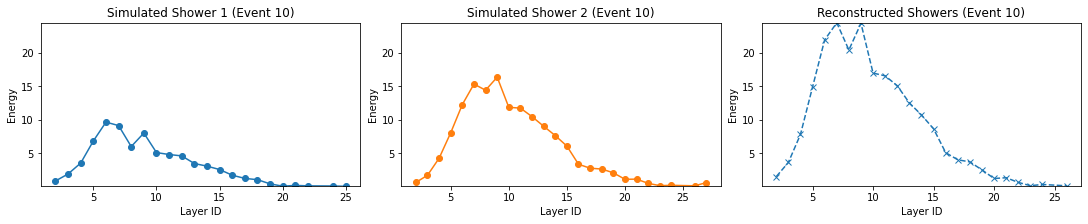

In [16]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters;3']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            # Loop over all Tracksters
            best_score = float('inf')
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, Calo_multi)
                if sim_to_reco_score < 0.2 and sim_to_reco_score < best_score:
                    best_score = sim_to_reco_score
                    best_tst_idx = trackster_idx
                    
            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events_ours = calculate_all_event_profile_data(GT_ind_filt, energies, MT_ind_filt, layer, GT_mult_filt)


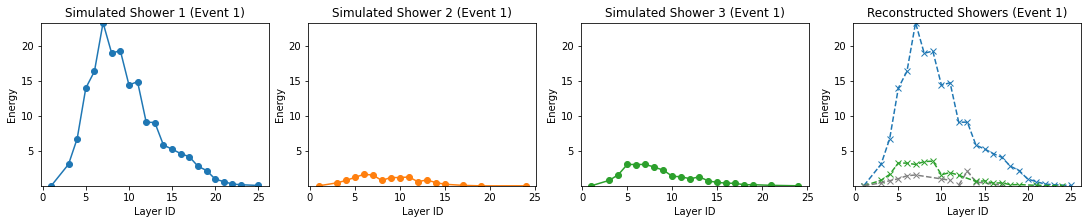

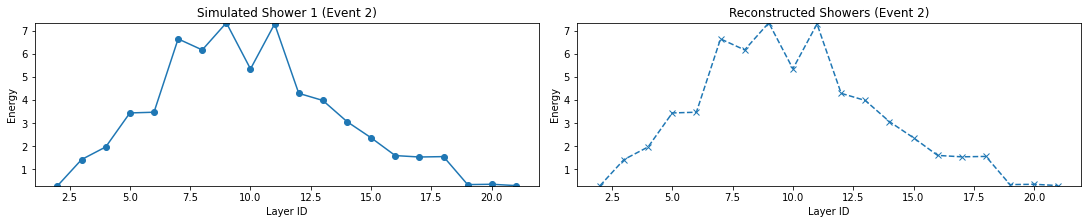

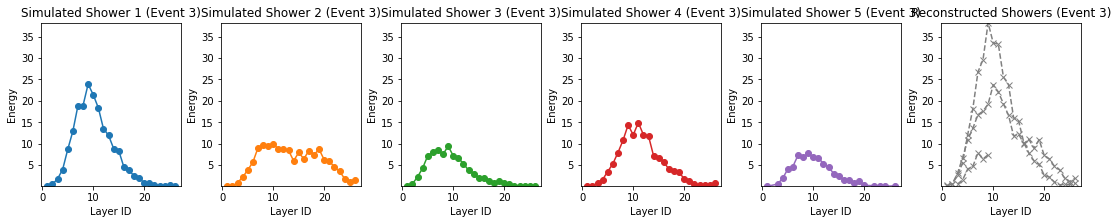

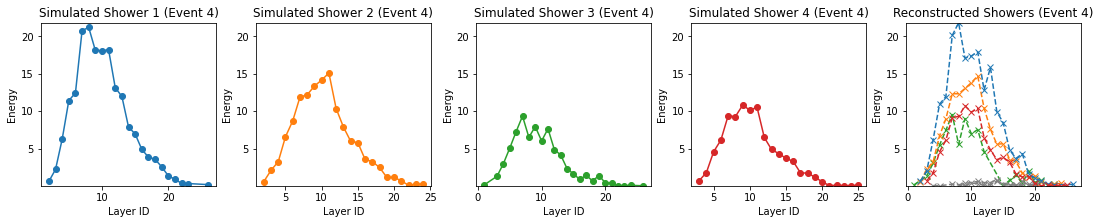

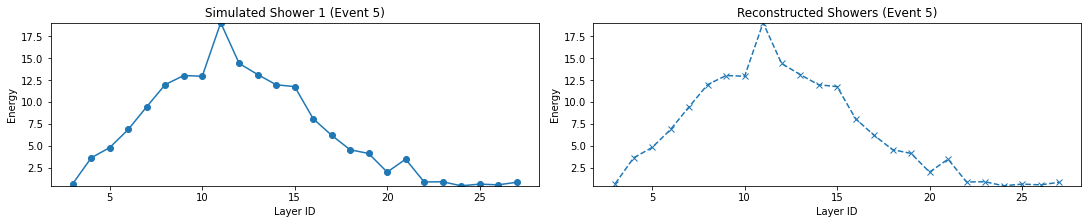

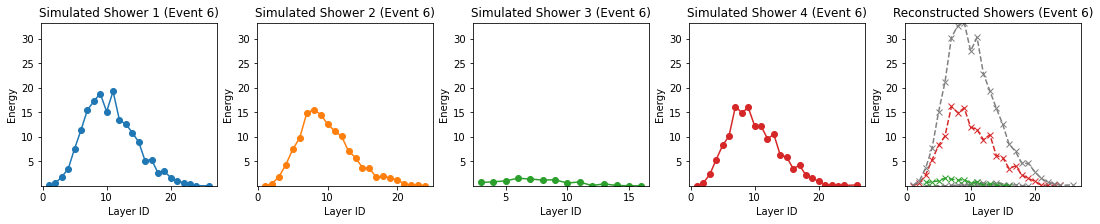

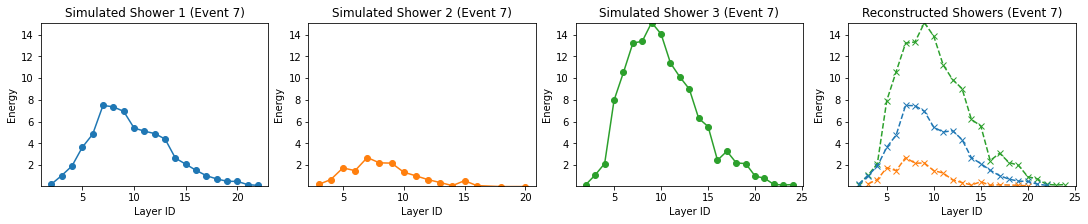

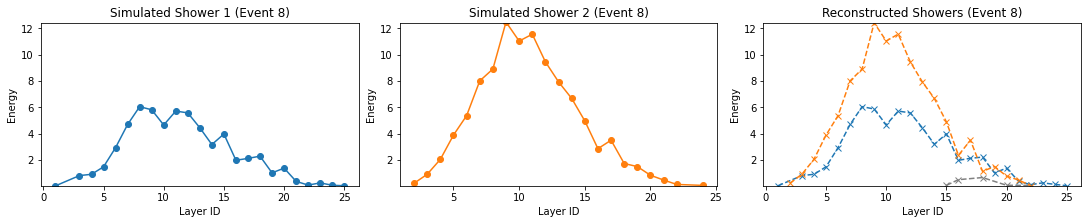

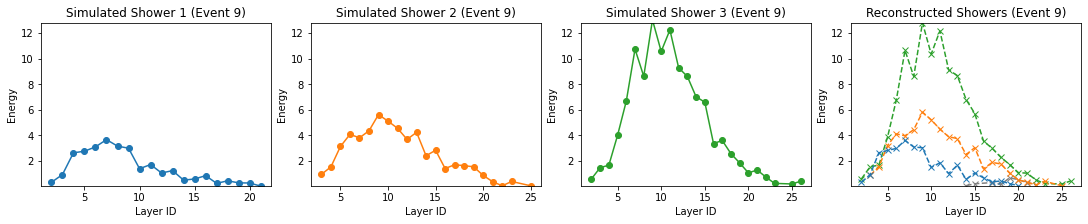

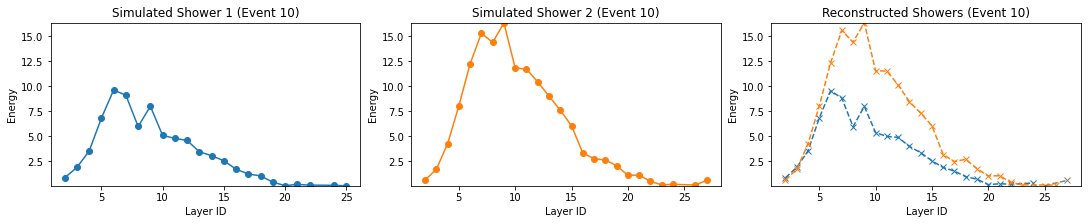

In [17]:
events_TICL = calculate_all_event_profile_data(GT_ind_filt, energies, recon_ind, layer, GT_mult_filt)